In [11]:
import os
import xml.sax
import copy
import networkx

In [12]:
def download_osm(left,bottom,right,top,highway_cat):
    """
    Downloads OSM street (only highway-tagged) Data using a BBOX, 
    plus a specification of highway tag values to use
    Parameters
    ----------
    left,bottom,right,top : BBOX of left,bottom,right,top coordinates in WGS84
    highway_cat : highway tag values to use, separated by pipes (|), for instance 'motorway|trunk|primary'
    Returns
    ----------
    stream object with osm xml data
    """

    #Return a filehandle to the downloaded data."""
    from urllib import urlopen
    #fp = urlopen( "http://api.openstreetmap.org/api/0.6/map?bbox=%f,%f,%f,%f"%(left,bottom,right,top) )
    #fp = urlopen( "http://www.overpass-api.de/api/xapi?way[highway=*][bbox=%f,%f,%f,%f]"%(left,bottom,right,top) )
    print("trying to download osm data from "+str(left),str(bottom),str(right),str(top)+" with highways of categories"+highway_cat)
    try:    
        print("downloading osm data from "+str(left),str(bottom),str(right),str(top)+" with highways of categories"+highway_cat)
        fp = urlopen( "http://www.overpass-api.de/api/xapi?way[highway=%s][bbox=%f,%f,%f,%f]"%(highway_cat,left,bottom,right,top) )
        #slooww only ways,and in ways only "highways" (i.e. roads)
        #fp = urlopen( "http://open.mapquestapi.com/xapi/api/0.6/way[highway=*][bbox=%f,%f,%f,%f]"%(left,bottom,right,top) )
        return fp
    except:
        print("osm data download unsuccessful")

def read_osm(filename_or_stream, only_roads=True):
    """Read graph in OSM format from file specified by name or by stream object.
    Parameters
    ----------
    filename_or_stream : filename or stream object
    Returns
    -------
    G : Graph
    Examples
    --------
    >>> G=nx.read_osm(nx.download_osm(-122.33,47.60,-122.31,47.61))
    >>> plot([G.node[n]['data'].lat for n in G], [G.node[n]['data'].lon for n in G], ',')
    """
    osm = OSM(filename_or_stream)
    G = networkx.DiGraph()

    for w in osm.ways.itervalues():
        if only_roads and 'highway' not in w.tags:
            continue
        G.add_path(w.nds, id=w.id, highway = w.tags['highway'], street= w.tags['name'])#{str(k): type(v) for k,v in w.tags.items()})
        
        if 'oneway' not in w.tags and  w.tags['highway'] != 'motorway':
            G.add_path(reversed(w.nds), id= '-' + str(w.id), highway = w.tags['highway'], street= w.tags['name'])

        elif w.tags['oneway'] != 'yes' and w.tags['oneway'] != '-1' and  w.tags['highway'] != 'motorway':
            G.add_path(reversed(w.nds), id=w.id, highway = w.tags['highway'], street= w.tags['name'])

        
    for n_id in G.nodes_iter():
        n = osm.nodes[n_id]
        G.node[n_id] = dict(lon=n.lon,lat=n.lat)
    return G


class Node:
    def __init__(self, id, lon, lat):
        self.id = id
        self.lon = lon
        self.lat = lat
        self.tags = {}
        
class Way:
    def __init__(self, id, osm):
        self.osm = osm
        self.id = id
        self.nds = []
        self.tags = {}
        
    def split(self, dividers):
        # slice the node-array using this nifty recursive function
        def slice_array(ar, dividers):
            for i in range(1,len(ar)-1):
                if dividers[ar[i]]>1:
                    #print "slice at %s"%ar[i]
                    left = ar[:i+1]
                    right = ar[i:]
                    
                    rightsliced = slice_array(right, dividers)
                    
                    return [left]+rightsliced
            return [ar]
            


        slices = slice_array(self.nds, dividers)
        
        # create a way object for each node-array slice
        ret = []
        i=0
        for slice in slices:
            littleway = copy.copy( self )
            littleway.id += "-%d"%i
            littleway.nds = slice
            ret.append( littleway )
            i += 1
            
        return ret
        

class OSM:
    def __init__(self, filename_or_stream):
        """ File can be either a filename or stream/file object."""
        nodes = {}
        ways = {}
        
        superself = self
        
        class OSMHandler(xml.sax.ContentHandler):
            @classmethod
            def setDocumentLocator(self,loc):
                pass
            
            @classmethod
            def startDocument(self):
                pass
                
            @classmethod
            def endDocument(self):
                pass
                
            @classmethod
            def startElement(self, name, attrs):
                if name=='node':
                    self.currElem = Node(attrs['id'], float(attrs['lon']), float(attrs['lat']))
                elif name=='way':
                    self.currElem = Way(attrs['id'], superself)
                elif name=='tag':
                    self.currElem.tags[attrs['k']] = attrs['v']
                elif name=='nd':
                    self.currElem.nds.append( attrs['ref'] )
                
            @classmethod
            def endElement(self,name):
                if name=='node':
                    nodes[self.currElem.id] = self.currElem
                elif name=='way':
                    ways[self.currElem.id] = self.currElem
                
            @classmethod
            def characters(self, chars):
                pass
 
        xml.sax.parse(filename_or_stream, OSMHandler)

        self.nodes = nodes
        self.ways = ways
        #"""   
        #count times each node is used
        node_histogram = dict.fromkeys( self.nodes.keys(), 0 )
        for way in self.ways.values():
            if len(way.nds) < 2:       #if a way has only one node, delete it out of the osm collection
                del self.ways[way.id]
            else:
                for node in way.nds:
                    node_histogram[node] += 1

        #use that histogram to split all ways, replacing the member set of ways
        new_ways = {}
        for id, way in self.ways.iteritems():
            split_ways = way.split(node_histogram)
            for split_way in split_ways:
                new_ways[split_way.id] = split_way
        self.ways = new_ways


In [13]:
"""
Read graphs in Open Street Maps osm format
Based on osm.py from brianw's osmgeocode
http://github.com/brianw/osmgeocode, which is based on osm.py from
comes from Graphserver:
http://github.com/bmander/graphserver/tree/master and is copyright (c)
2007, Brandon Martin-Anderson under the BSD License
"""

import xml.sax
import copy
import networkx

#highway_cat = 'motorway|trunk|primary|secondary|tertiary|road|residential|service|motorway_link|trunk_link|primary_link|secondary_link|teriary_link'

def download_osm(left,bottom,right,top,highway_cat):
    """
    Downloads OSM street (only highway-tagged) Data using a BBOX, 
    plus a specification of highway tag values to use
    Parameters
    ----------
    left,bottom,right,top : BBOX of left,bottom,right,top coordinates in WGS84
    highway_cat : highway tag values to use, separated by pipes (|), for instance 'motorway|trunk|primary'
    Returns
    ----------
    stream object with osm xml data
    """

    #Return a filehandle to the downloaded data."""
    from urllib import urlopen
    #fp = urlopen( "http://api.openstreetmap.org/api/0.6/map?bbox=%f,%f,%f,%f"%(left,bottom,right,top) )
    #fp = urlopen( "http://www.overpass-api.de/api/xapi?way[highway=*][bbox=%f,%f,%f,%f]"%(left,bottom,right,top) )
    print("trying to download osm data from "+str(left),str(bottom),str(right),str(top)+" with highways of categories"+highway_cat)
    try:    
        print("downloading osm data from "+str(left),str(bottom),str(right),str(top)+" with highways of categories"+highway_cat)
        fp = urlopen( "http://www.overpass-api.de/api/xapi?way[highway=%s][bbox=%f,%f,%f,%f]"%(highway_cat,left,bottom,right,top) )
        #slooww only ways,and in ways only "highways" (i.e. roads)
        #fp = urlopen( "http://open.mapquestapi.com/xapi/api/0.6/way[highway=*][bbox=%f,%f,%f,%f]"%(left,bottom,right,top) )
        return fp
    except:
        print("osm data download unsuccessful")

def read_osm(filename_or_stream, only_roads=True):
    """Read graph in OSM format from file specified by name or by stream object.
    Parameters
    ----------
    filename_or_stream : filename or stream object
    Returns
    -------
    G : Graph
    Examples
    --------
    >>> G=nx.read_osm(nx.download_osm(-122.33,47.60,-122.31,47.61))
    >>> plot([G.node[n]['data'].lat for n in G], [G.node[n]['data'].lon for n in G], ',')
    """
    osm = OSM(filename_or_stream)
    G = networkx.DiGraph()
 
    for w in osm.ways.itervalues():
        if only_roads and 'highway' not in w.tags:
            continue
        G.add_path(w.nds, id=w.id, highway = w.tags['highway'], street= w.tags['name'])#{str(k): type(v) for k,v in w.tags.items()})
        
        if 'oneway' not in w.tags and  w.tags['highway'] != 'motorway':
            G.add_path(reversed(w.nds), id= '-' + str(w.id), highway = w.tags['highway'], street= w.tags['name'])

        elif w.tags['oneway'] != 'yes' and w.tags['oneway'] != '-1' and  w.tags['highway'] != 'motorway':
            G.add_path(reversed(w.nds), id=w.id, highway = w.tags['highway'], street= w.tags['name'])

        
    for n_id in G.nodes_iter():
        n = osm.nodes[n_id]
        G.node[n_id] = dict(lon=n.lon,lat=n.lat)
    return G
        
    
class Node:
    def __init__(self, id, lon, lat):
        self.id = id
        self.lon = lon
        self.lat = lat
        self.tags = {}
        
class Way:
    def __init__(self, id, osm):
        self.osm = osm
        self.id = id
        self.nds = []
        self.tags = {}
        
    def split(self, dividers):
        # slice the node-array using this nifty recursive function
        def slice_array(ar, dividers):
            for i in range(1,len(ar)-1):
                if dividers[ar[i]]>1:
                    #print "slice at %s"%ar[i]
                    left = ar[:i+1]
                    right = ar[i:]
                    
                    rightsliced = slice_array(right, dividers)
                    
                    return [left]+rightsliced
            return [ar]
            


        slices = slice_array(self.nds, dividers)
        
        # create a way object for each node-array slice
        ret = []
        i=0
        for slice in slices:
            littleway = copy.copy( self )
            littleway.id += "-%d"%i
            littleway.nds = slice
            ret.append( littleway )
            i += 1
            
        return ret
        

class OSM:
    def __init__(self, filename_or_stream):
        """ File can be either a filename or stream/file object."""
        nodes = {}
        ways = {}
        
        superself = self
        
        class OSMHandler(xml.sax.ContentHandler):
            @classmethod
            def setDocumentLocator(self,loc):
                pass
            
            @classmethod
            def startDocument(self):
                pass
                
            @classmethod
            def endDocument(self):
                pass
                
            @classmethod
            def startElement(self, name, attrs):
                if name=='node':
                    self.currElem = Node(attrs['id'], float(attrs['lon']), float(attrs['lat']))
                elif name=='way':
                    self.currElem = Way(attrs['id'], superself)
                elif name=='tag':
                    self.currElem.tags[attrs['k']] = attrs['v']
                elif name=='nd':
                    self.currElem.nds.append( attrs['ref'] )
                
            @classmethod
            def endElement(self,name):
                if name=='node':
                    nodes[self.currElem.id] = self.currElem
                elif name=='way':
                    ways[self.currElem.id] = self.currElem
                
            @classmethod
            def characters(self, chars):
                pass
 
        xml.sax.parse(filename_or_stream, OSMHandler)
        
        self.nodes = nodes
        self.ways = ways
        #count times each node is used
        node_histogram = dict.fromkeys( self.nodes.keys(), 0 )
        for way in self.ways.values():
            if len(way.nds) < 2:       #if a way has only one node, delete it out of the osm collection
                del self.ways[way.id]
            else:
                for node in way.nds:
                    node_histogram[node] += 1
        
        #use that histogram to split all ways, replacing the member set of ways
        new_ways = {}
        for id, way in self.ways.iteritems():
            split_ways = way.split(node_histogram)
            for split_way in split_ways:
                new_ways[split_way.id] = split_way
        self.ways = new_ways

In [14]:
# To fix an error
import os
os.environ['PROJ_LIB'] = 'C:\\Users\\kevin\\miniconda3\\envs\\crime\\Library\\share\\proj'
os.environ['GDAL_DATA'] = 'C:\\Users\\kevin\\miniconda3\\envs\\crime\\Library\\share'

In [15]:
import osmnx as ox
import networkx as nx
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import geojson as gj
import json

C:\Users\kevin\AppData\Roaming\Python\Python39\site-packages\osmnx\geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


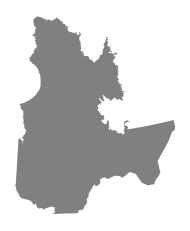

In [16]:
state = ox.geocode_to_gdf('Quebec, CA')
ax = ox.project_gdf(state).plot(fc='gray', ec='none')
_ = ax.axis('off')

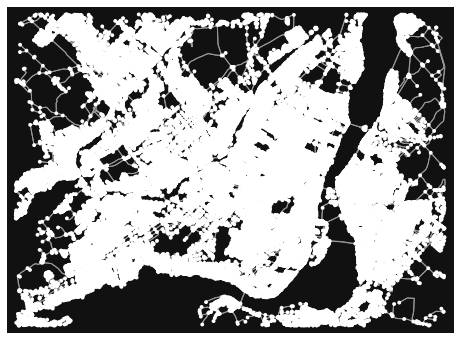

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [10]:
# Defining the map boundaries 
north, east, south, west = 45.6923, -73.3736, 45.3874, -73.9730  
# Downloading the map as a graph object 
G = ox.graph_from_bbox(north, south, east, west, network_type = 'drive')  
# Plotting the map graph 
ox.plot_graph(G)

In [17]:
def path_finder(solutiondoc):
    stations = pd.read_csv('data/pdq.csv')
    fp = open(solutiondoc)
    words = [word.strip() for line in fp.readlines() for word in line.split(',') if word.strip()]
    print(words)

In [22]:
origin_point = (45.5173538,-73.58212888)
destination_point = (45.539385081961676,-73.54099988937377)
# get the nearest nodes to the locations 
origin_node = ox.get_nearest_node(G, origin_point) 
destination_node = ox.get_nearest_node(G, destination_point)
# Finding the optimal path 
route = nx.shortest_path(G, origin_node, destination_node, weight = 'length')
print(route)

C:\Users\kevin\AppData\Roaming\Python\Python39\site-packages\osmnx\distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
C:\Users\kevin\AppData\Roaming\Python\Python39\site-packages\osmnx\distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)


[29794135, 29784599, 133342201, 208932417, 3577140054, 208932355, 208932395, 208932380, 182070156, 9001637867, 209424689, 9015647961, 9015557882, 209424721, 6896814378, 209424753, 209424759, 30451686, 209424746, 32585979, 209424929, 209473668, 209473608, 209473612, 209473664, 438303032, 209481363, 209481366, 209481369, 438304349, 209481435, 209481473, 209473970, 209493244, 209493248, 209493251, 209493254, 209507837, 209508036, 209493262, 209493266, 209493291, 209508004, 209493441, 209493445, 9297254159, 209508009, 209493467, 218343986, 209507991, 218315741, 218315532, 218315535, 218344052]


In [23]:
route_pd = pd.DataFrame(route)
route_pd.to_csv('path.csv', index = False)

In [24]:
#store long, lat
long = [] 
lat = []  
for i in route:
     point = G.nodes[i]
     long.append(point['x'])
     lat.append(point['y'])

In [26]:
json_path

NameError: name 'json_path' is not defined

In [27]:
route_pd = [lat, long]
route_pd = pd.DataFrame(route_pd)
route_pd = route_pd.T
data = json.loads(json_path)
data['features'][0]['geometry'] #Your first point
#route_pd.to_csv('path.csv', index = False)
#route_pd

NameError: name 'json_path' is not defined

In [ ]:
#store long, lat
""""string = ""{
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {
        "vendor":  "A"
      },
      "geometry": {
        "type": "LineString",
        "coordinates": [
          [-74.20986, 40.81773, 0],
          [-74.20987, 40.81765, 0],
          [-74.20998, 40.81746, 0]
        ]
      }
    }
  ]
}"""
first_string = "{\"type\": \"FeatureCollection\",\"features\": [{\"type\": \"Feature\",\"properties\": {\"vendor\":  \"A\"},\"geometry\": {\"type\": \"LineString\",\"coordinates\": [ "
coordinates = ""
long = [] 
lat = []  
for i in route: 
    point = G.nodes[i]
    print(point)
    long.append(point['x'])
    lat.append(point['y'])
    long_lat = "[" + str(point['x']) + "," + str(point['y']) + "],\n"
    coordinates += long_lat
final_string = "]}}]}"
string = first_string + coordinates + final_string
print(string)
print(len(route))
file2write=open("pathh",'w')
file2write.write(string)
file2write.close()

In [ ]:
"""import pandas as pd
import geojson

def data2geojson(df):
    features = []
    insert_features = lambda X: features.append(
            geojson.Feature(geometry=geojson.Point((X["long"],
                                                    X["lat"]))))
    df.apply(insert_features, axis=1)
    with open('map1.geojson', 'w', encoding='utf8') as fp:
        geojson.dump(geojson.FeatureCollection(features), fp, sort_keys=True, ensure_ascii=False)

col = ['lat','long']
data = [[-29.9953,-70.5867],
        [-30.1217,-70.4933],
        [-30.0953,-70.5008]]

df = pd.DataFrame(data, columns=col)
data2geojson(df)
print(df)"""